# DLMI - Lymphocytosis classification
## One image one label models with augmented data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader

from ..utils import trainer
from one_image_one_label import (
    ImageLabelDataset, 
    ImageDataset, 
    image_to_numpy, 
    load_images, 
    assign_labels,
    predict
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_dir = "../../data/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"
augmented_data_dir = "../../data/dlmi-lymphocytosis-augmented-data"

In [4]:
train_val_images = load_images(train_dir)
test_images = load_images(test_dir)

In [5]:
augmented_images = {"augmented": []}
for image_path in os.listdir(augmented_data_dir):
    augmented_images["augmented"].append(os.path.join(augmented_data_dir, image_path))

../data/dlmi-lymphocytosis-classification/testset/P197/000034.jpg
(224, 224, 3)


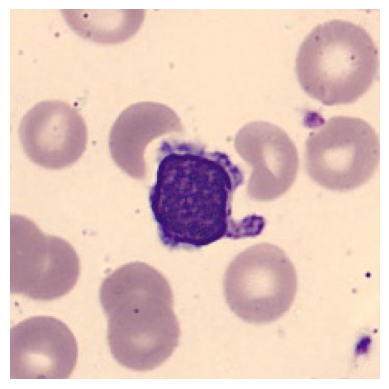

In [6]:
image_path = list(test_images.values())[5][10]
print(image_path)
image = image_to_numpy(image_path)
print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

In [7]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
labels_dict = dict(zip(trainset_true_df["ID"], trainset_true_df["LABEL"]))

In [8]:
n_id_val_per_class = 20

id_train_val = np.array(list(train_val_images.keys()))
labels = np.array([labels_dict[id] for id in id_train_val])

id_train_val_0 = id_train_val[labels == 0]
id_train_val_1 = id_train_val[labels == 1]

id_val_0 = np.random.choice(id_train_val_0, size=n_id_val_per_class, replace=False)
id_val_1 = np.random.choice(id_train_val_1, size=n_id_val_per_class, replace=False)

id_val = np.concatenate([id_val_0, id_val_1])
mask = np.isin(id_train_val, id_val, invert=True)
id_train = id_train_val[mask]

id_train.shape, id_val.shape

((123,), (40,))

In [9]:
train_images = {id: train_val_images[id] for id in id_train}
val_images = {id: train_val_images[id] for id in id_val}

X_train, y_train = assign_labels(train_images, labels_dict)
X_val, y_val = assign_labels(val_images, labels_dict)
len(X_train), len(X_val)

(10485, 2968)

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1518, 8967]))

In [11]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([1074, 1894]))

In [12]:
n_images = len(augmented_images["augmented"])
X_train.extend(augmented_images["augmented"][:n_images])
y_train.extend([0]*n_images)
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8794, 8967]))

In [13]:
transform_function = lambda x: x.reshape(3, x.shape[0], x.shape[1])

In [14]:
batch_size = 32
train_dataset = ImageLabelDataset(X_train, y_train, transform_function)
test_dataset = ImageLabelDataset(X_val, y_val, transform_function)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Sequential(
                nn.Linear(12544, 2048),
                nn.ReLU(),
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 32),
                nn.ReLU(),
                nn.Linear(32, 8),
                nn.ReLU(),
                nn.Linear(8, 2)
            )
        )

    def forward(self, x):
        return self.model(x)

[Epoch 10 / 20] train loss = 0.19 acc = 0.92  test loss = 0.65 acc = 0.66
[Epoch 20 / 20] train loss = 0.69 acc = 0.50  test loss = 0.69 acc = 0.64


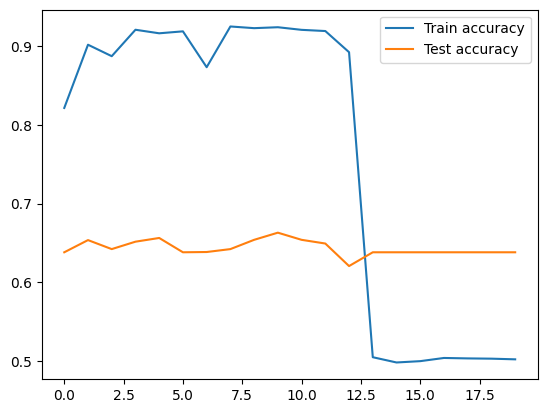

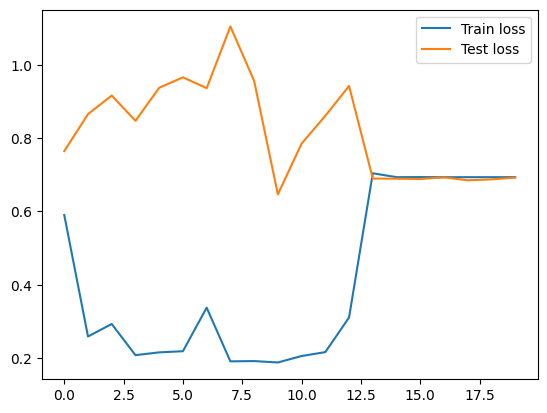

In [16]:
model = CNN().to(device)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 20
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [17]:
def predict_all(model, images_dict, transform_function, batch_size, device):
    y_pred = []
    for p, p_images in images_dict.items():
        p_dataset = ImageDataset(p_images, transform_function)
        p_dataloader = DataLoader(p_dataset, batch_size=batch_size, shuffle=False)
        y = predict(model, p_dataloader, device)
        y_pred.append(y)
    return np.array(y_pred)

In [18]:
y_true_val = np.array([labels_dict[p] for p in val_images.keys()])
y_pred = predict_all(model, val_images, transform_function, batch_size=batch_size, device=device)

In [19]:
y_true_val, y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [20]:
acc = metrics.accuracy_score(y_true_val, y_pred)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred)
print(f"acc = {acc:.2f} bal. acc = {balanced_acc:.2f}")

acc = 0.50 bal. acc = 0.50
